Collecting data from Yahoo Finance using yfinance library.

In [10]:
import yfinance as yf

tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "^GSPC"]
start_date = "2020-01-01"
end_date = "2024-12-31"

data = {ticker: yf.download(ticker, start=start_date, end=end_date) for ticker in tickers}

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Data Preprocessing

In [13]:
import pandas as pd
from ta.momentum import RSIIndicator
from sklearn.preprocessing import MinMaxScaler

def preprocess_stock_data(df):
    df = df.copy()

    # calculate moving average
    df['MA_20'] = df['Close'].rolling(window=20).mean()

    # ensure Close is 1D Series for RSIIndicator
    close_series = df['Close'].squeeze()
    if isinstance(close_series, pd.DataFrame):  # just in case
        close_series = close_series.iloc[:, 0]

    # compute RSI
    rsi = RSIIndicator(close=close_series, window=14, fillna=True).rsi()
    df['RSI'] = rsi

    # remove rows with NaN values
    df.dropna(inplace=True)

    # normalization using MinMaxScaler
    scaler = MinMaxScaler()
    scaled_values = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume']])
    scaled_df = pd.DataFrame(scaled_values, index=df.index, columns=['Open', 'High', 'Low', 'Close', 'Volume'])

    # include technical indicators
    scaled_df['MA_20'] = df['MA_20'].values
    scaled_df['RSI'] = df['RSI'].values

    return scaled_df

# execute preprocessing in every ticker
preprocessed_data = {}
for ticker in tickers:
    df = data[ticker]
    try:
        preprocessed_data[ticker] = preprocess_stock_data(df)
        print(f"{ticker} preprocessing completed successfully.")
    except Exception as e:
        print(f"{ticker} error during preprocessing: {e}")

AAPL preprocessing completed successfully.
MSFT preprocessing completed successfully.
GOOGL preprocessing completed successfully.
AMZN preprocessing completed successfully.
TSLA preprocessing completed successfully.
^GSPC preprocessing completed successfully.


EDA


 EDA for AAPL


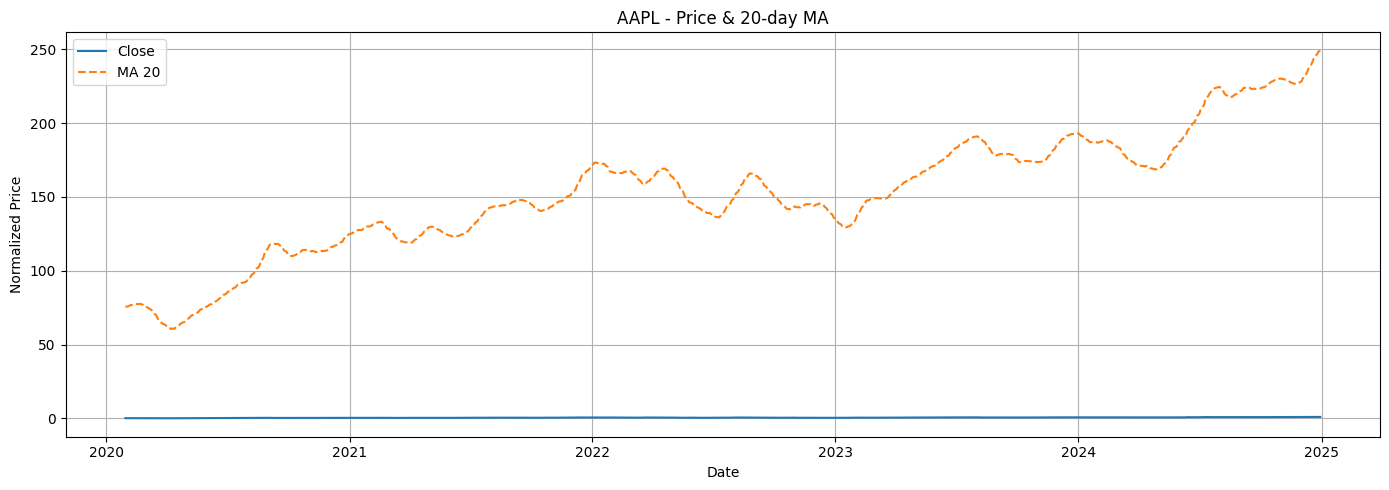

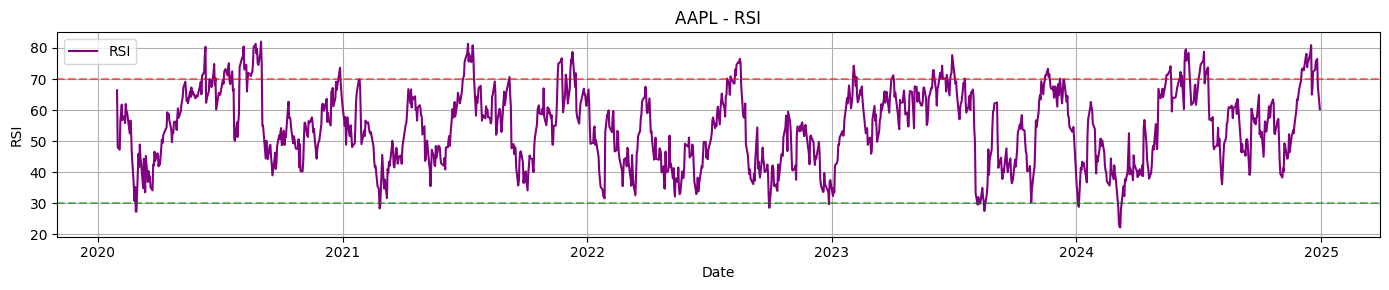

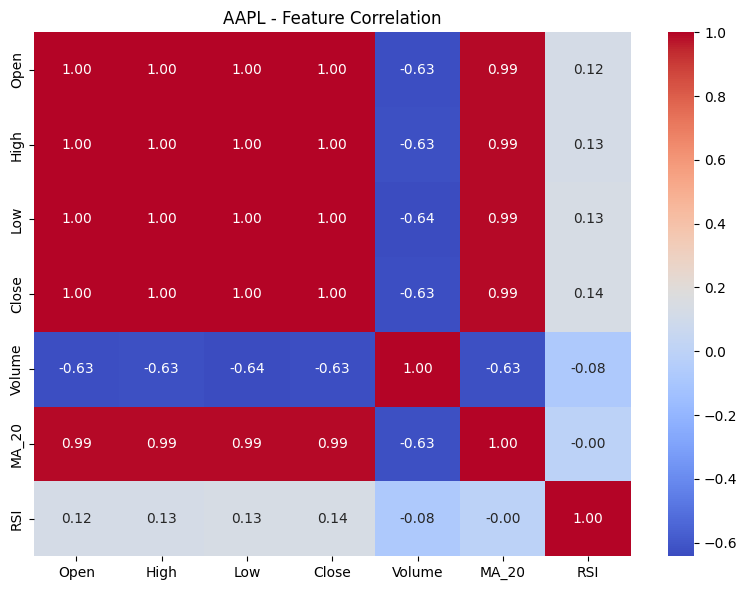

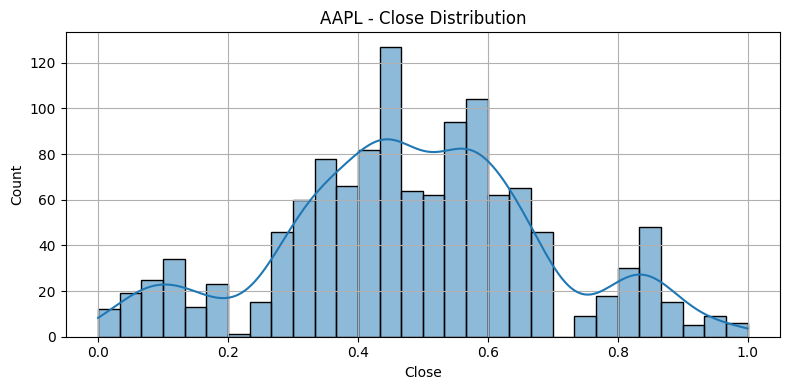


 EDA for MSFT


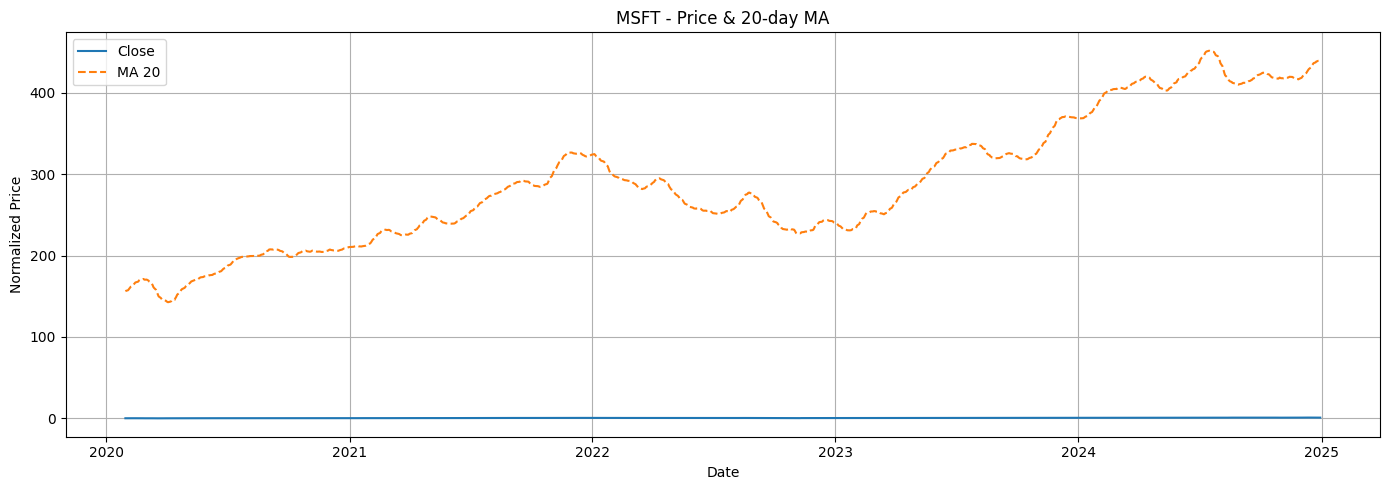

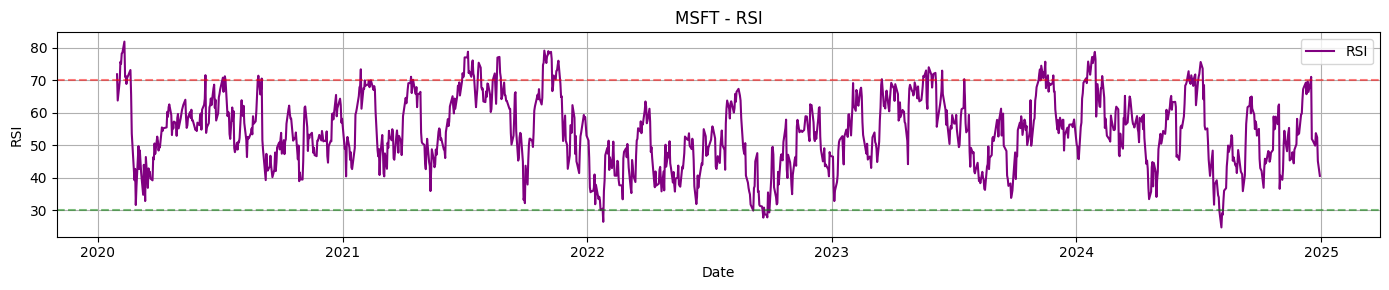

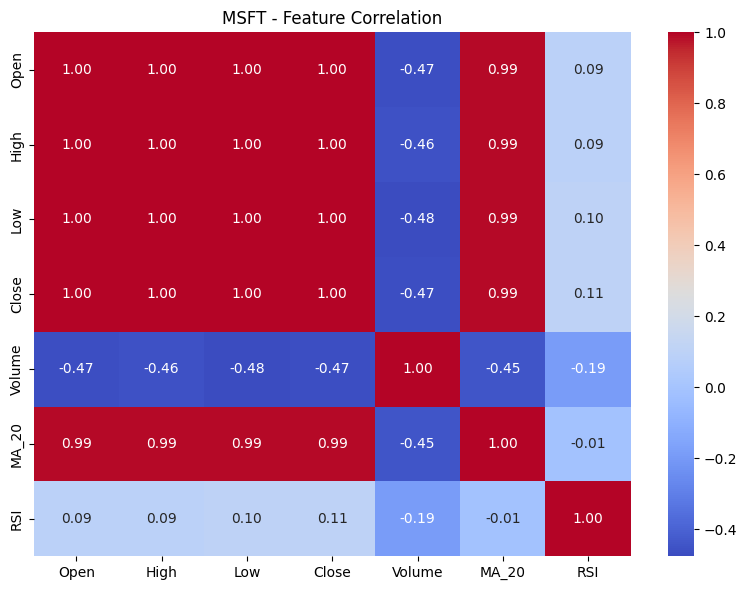

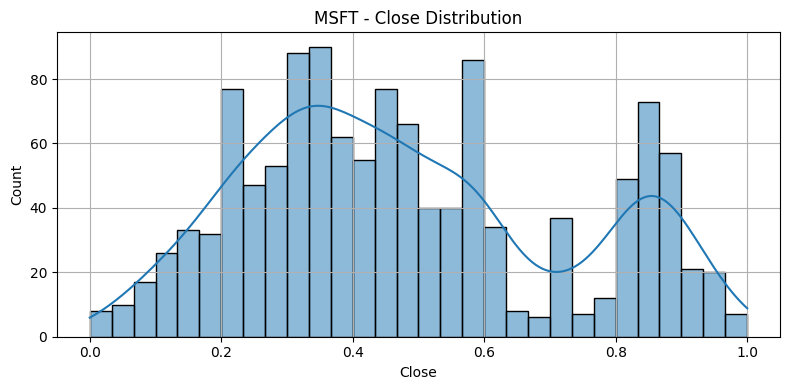


 EDA for GOOGL


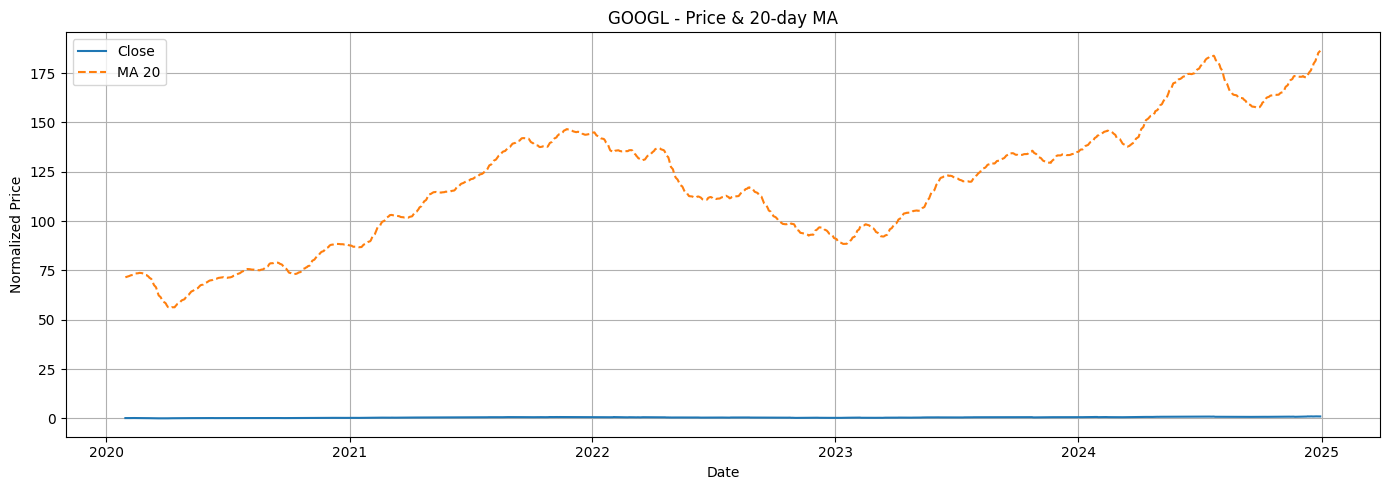

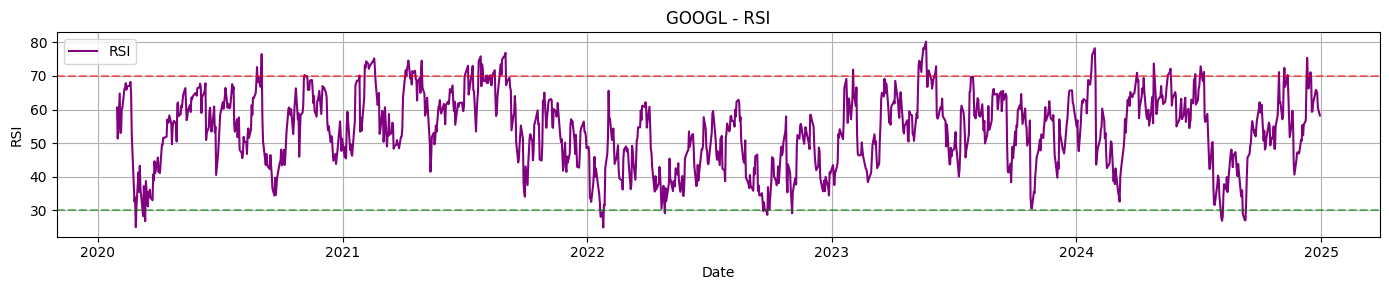

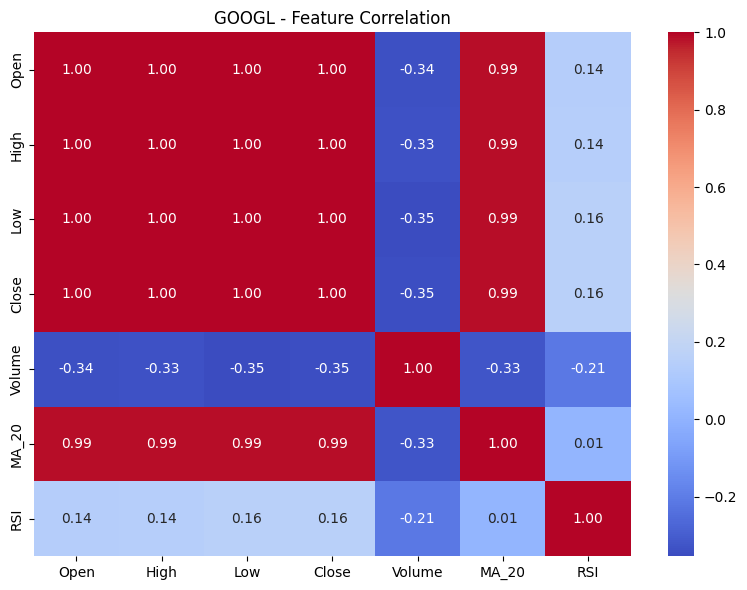

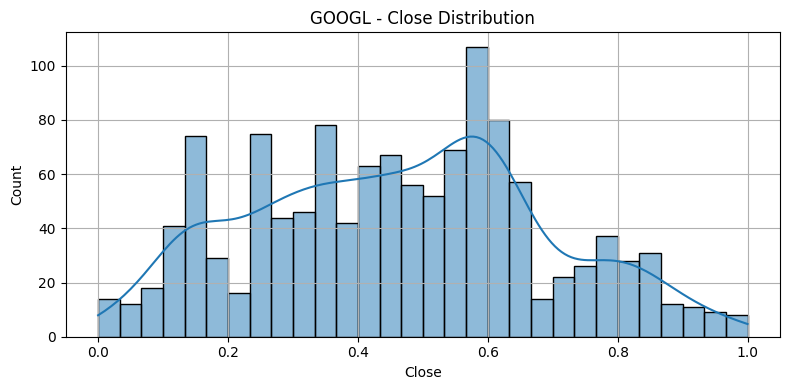


 EDA for AMZN


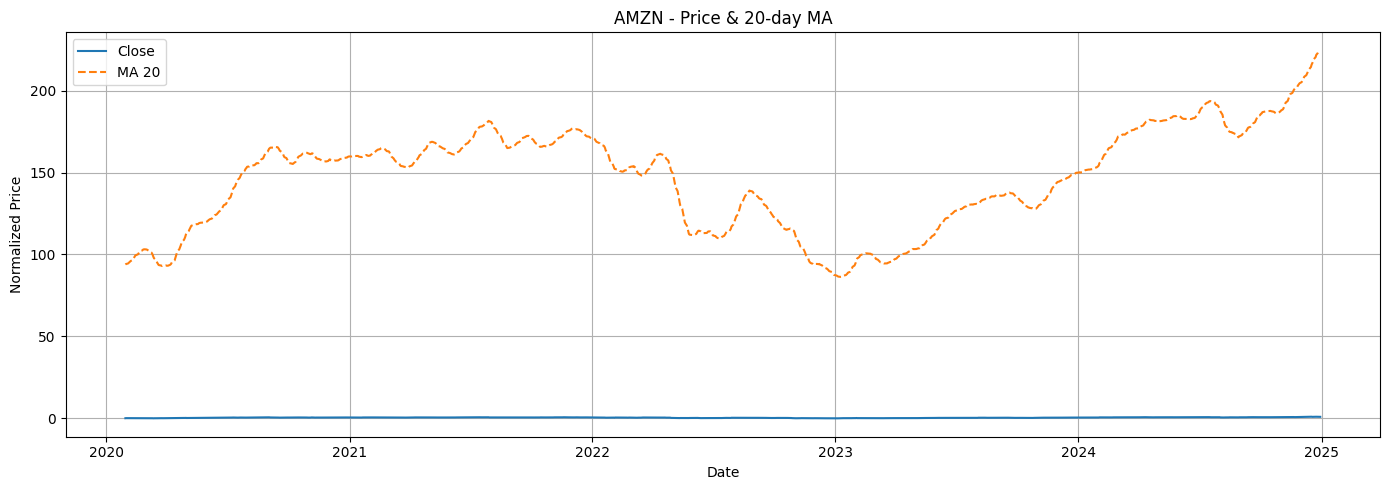

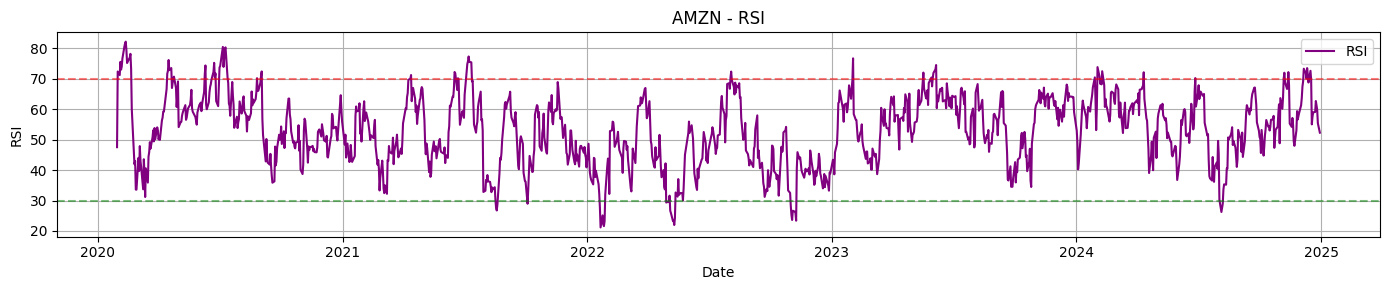

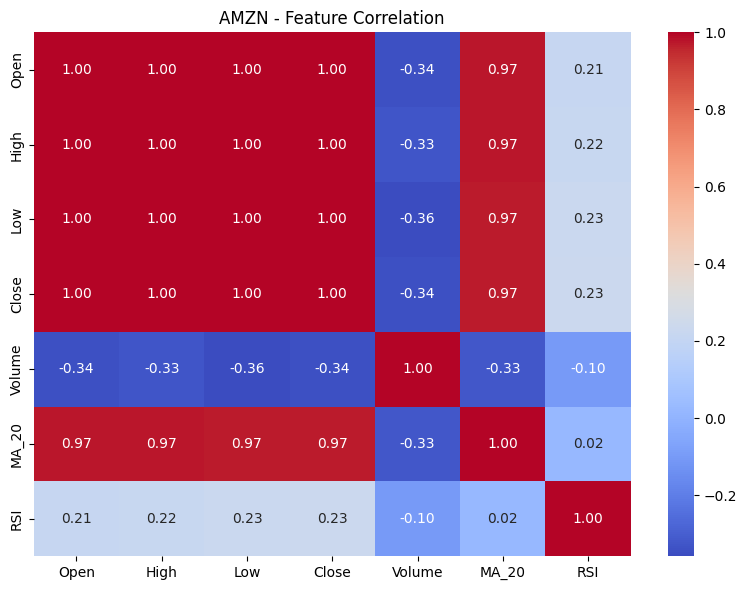

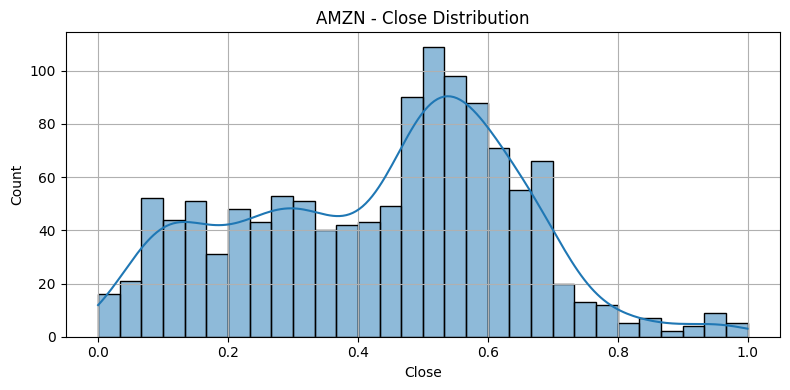


 EDA for TSLA


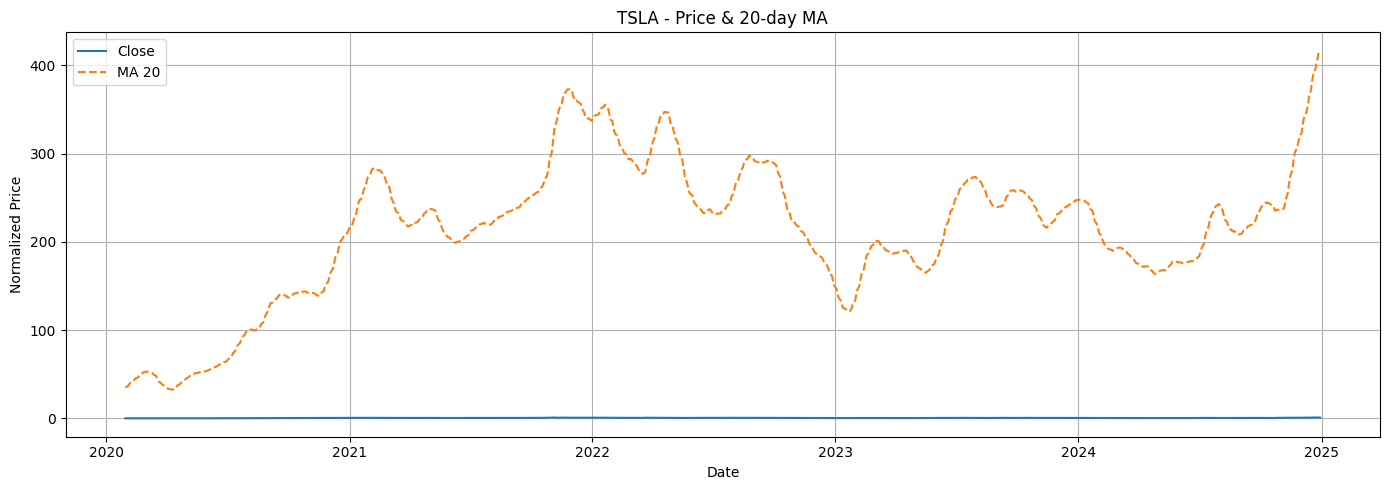

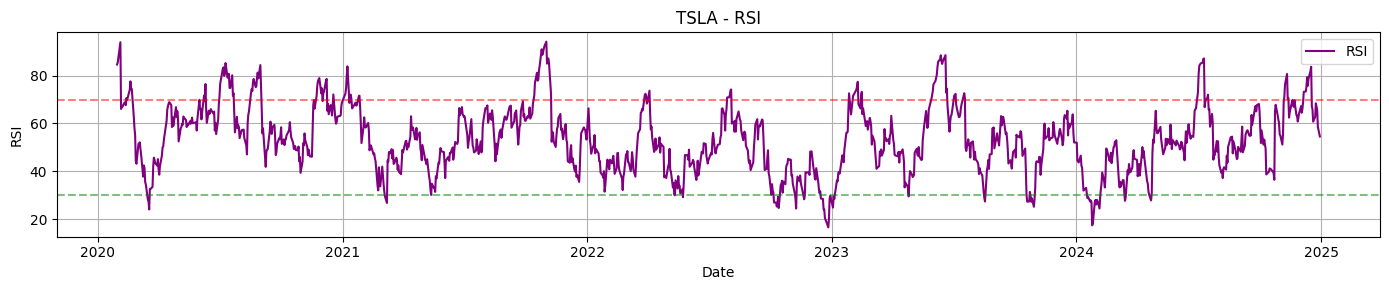

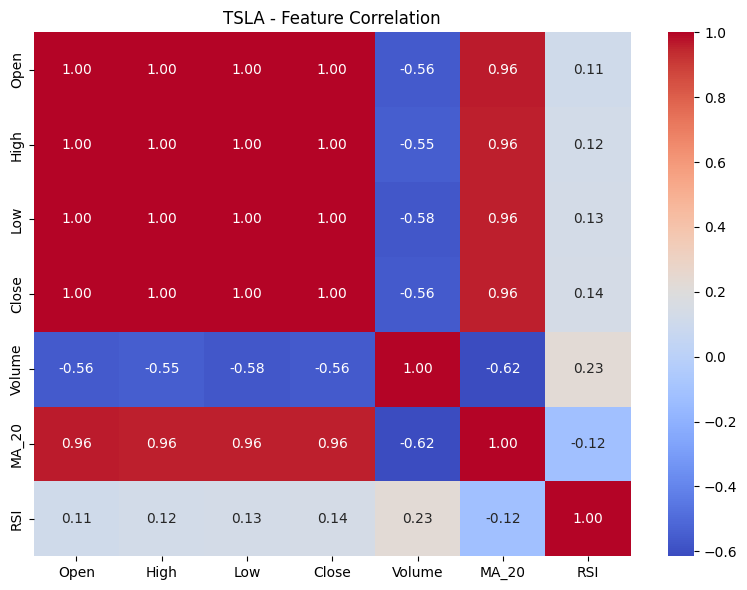

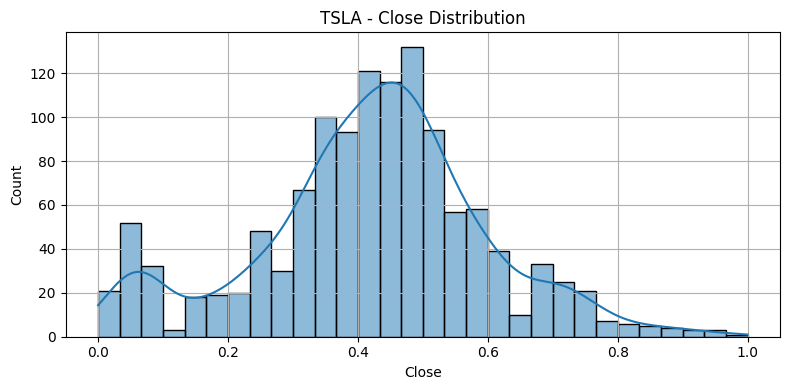


 EDA for ^GSPC


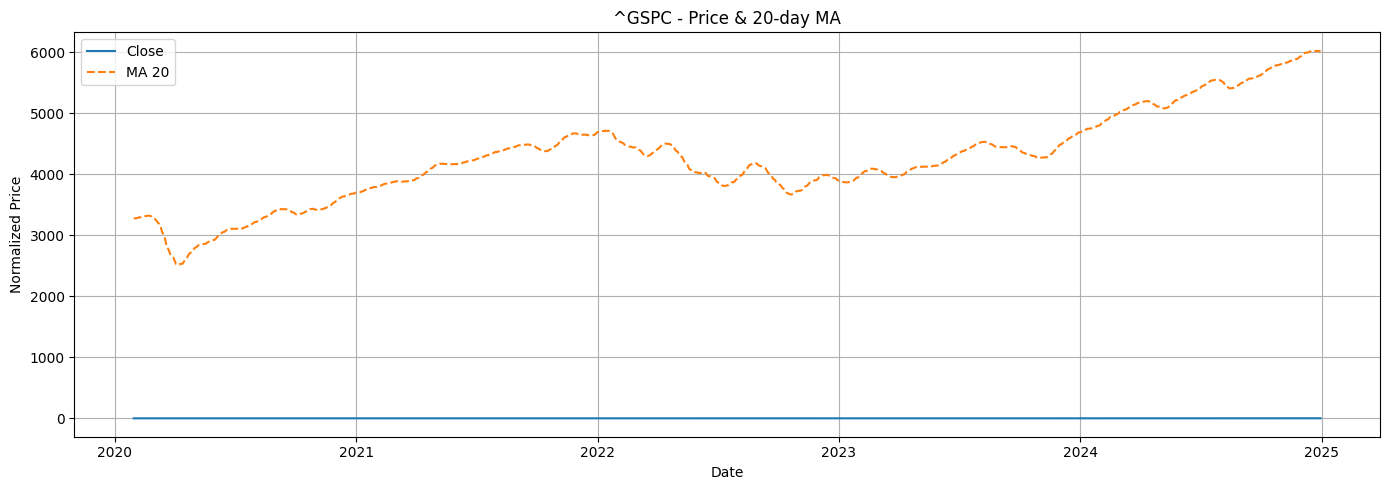

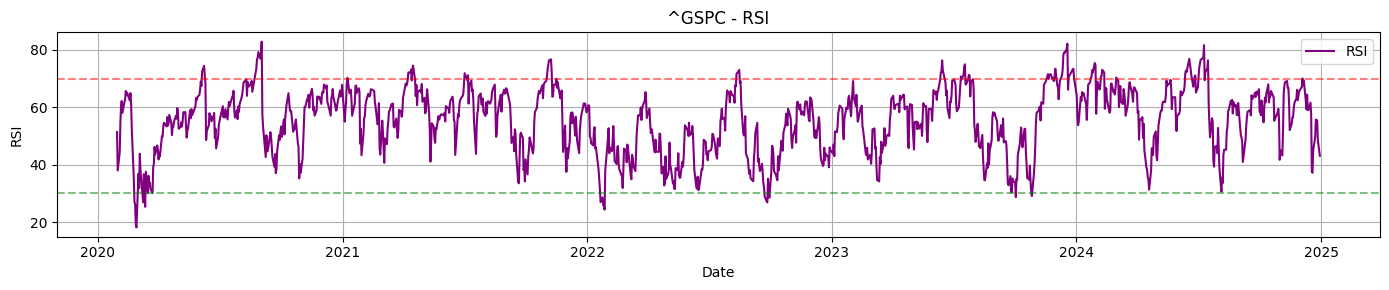

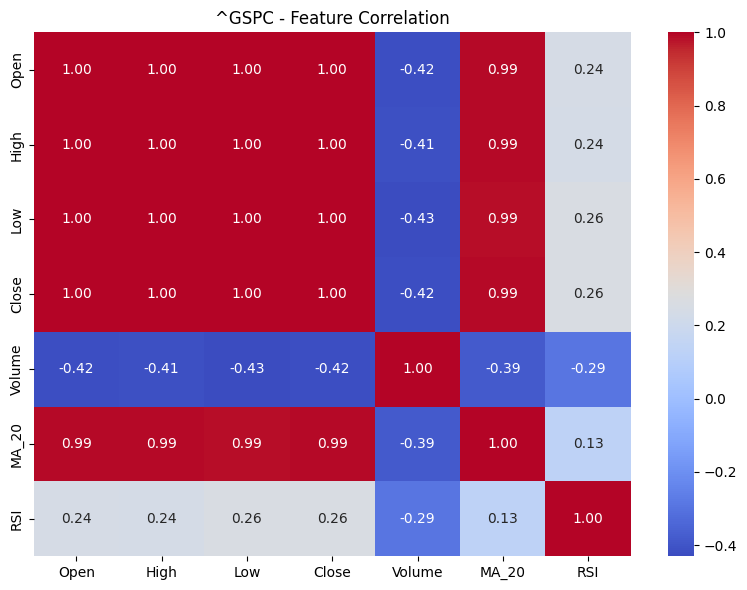

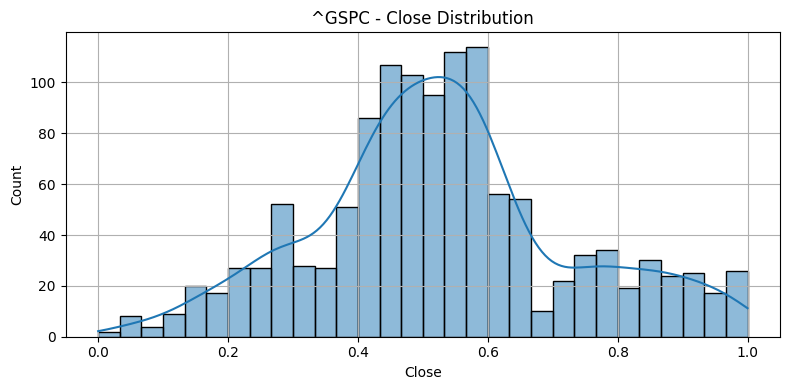

In [14]:
# Jupyter Notebook -- set graph output
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

# visualize price tendency and average movement
def plot_price_trend(ticker, df):
    plt.figure(figsize=(14, 5))
    plt.plot(df['Close'], label='Close')
    plt.plot(df['MA_20'], label='MA 20', linestyle='--')
    plt.title(f"{ticker} - Price & 20-day MA")
    plt.xlabel("Date")
    plt.ylabel("Normalized Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# visualize RSI
def plot_rsi(ticker, df):
    plt.figure(figsize=(14, 3))
    plt.plot(df['RSI'], label='RSI', color='purple')
    plt.axhline(70, color='red', linestyle='--', alpha=0.5)
    plt.axhline(30, color='green', linestyle='--', alpha=0.5)
    plt.title(f"{ticker} - RSI")
    plt.xlabel("Date")
    plt.ylabel("RSI")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# correlation hitmap
def plot_correlation_heatmap(ticker, df):
    plt.figure(figsize=(8, 6))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
    plt.title(f"{ticker} - Feature Correlation")
    plt.tight_layout()
    plt.show()

# distribution in increase analysis
def plot_distribution(ticker, df, column='Close'):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f"{ticker} - {column} Distribution")
    plt.xlabel(column)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ================================
# auto-execute EDA
# ================================
for ticker in tickers:
    print(f"\n EDA for {ticker}")
    try:
        df = preprocessed_data[ticker]
        plot_price_trend(ticker, df)
        plot_rsi(ticker, df)
        plot_correlation_heatmap(ticker, df)
        plot_distribution(ticker, df, column='Close')
    except Exception as e:
        print(f"{ticker} EDA error: {e}")